# Jaka Rizmal

Gručenje držav glede na podobnost rasti okuženih za Covid-19.

In [1]:
import pandas as pd

# Reading data
dataFrame = pd.read_table("../podatki/corona_latest.csv",sep=",",usecols=[0,4,5,6,9])

# Converting column to datetime dtype
dataFrame["dateRep"] = pd.to_datetime(dataFrame["dateRep"],format= "%d/%m/%Y")

# Extracting min and max dates
dateMin = dataFrame["dateRep"].min()
dateMax = dataFrame["dateRep"].max()

In [2]:
# Creating a weekly date range
dateRange = pd.date_range(dateMin,dateMax,freq="W")

# Getting all countries
countries = dataFrame["countriesAndTerritories"].unique()

In [3]:
weeklyStats = dict()

# Iterate through countries and calculate weekly cases and deaths
for currentCountry in countries:
    weeklyStats[currentCountry] = []
    rows = dataFrame[dataFrame["countriesAndTerritories"]==currentCountry]
    for i in range(len(dateRange)):
        if i >= len(dateRange)-1:
            break
        # Select rows between this and next dateRange item
        week = rows[(rows["dateRep"]>=dateRange[i])&(rows["dateRep"]<dateRange[i+1])]
        # Iterate through weeks and sum cases and deaths, add to weeklyStats
        weeklyStats[currentCountry].append([week["cases"].sum(),week["deaths"].sum()])    

In [4]:
weeklyCoefs = dict()

# Calculate growth coefficients between weeks
for country in weeklyStats.keys():
    weeks = weeklyStats[country]
    casesCoefs = []
    deathsCoefs = []
    for i in range(len(weeks)):
        if i>=len(weeks)-1:
            break
        if weeks[i][0]==0:
            casesCoefs.append(0)
        else:
            casesCoefs.append(weeks[i+1][0]/weeks[i][0])
        if weeks[i][1] == 0:
            deathsCoefs.append(0)
        else:
            deathsCoefs.append(weeks[i+1][1]/weeks[i][1])
    weeklyCoefs[country]=[]
    weeklyCoefs[country].append(casesCoefs)
    weeklyCoefs[country].append(deathsCoefs)

In [5]:
import random
random.seed(66)
# labels = random.sample(list(weeklyCoefs.keys()),100)
labels = weeklyCoefs.keys()

caseMatrix = []
deathMatrix = []

# Create a matrix of coefficients
for country in labels:
    caseMatrix.append(weeklyCoefs[country][0])
    deathMatrix.append(weeklyCoefs[country][1])
    
labels = list(weeklyCoefs.keys())

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Create clustering model
linkage = sch.linkage(caseMatrix, method="weighted")
# plt.figure(figsize=(45, 15))

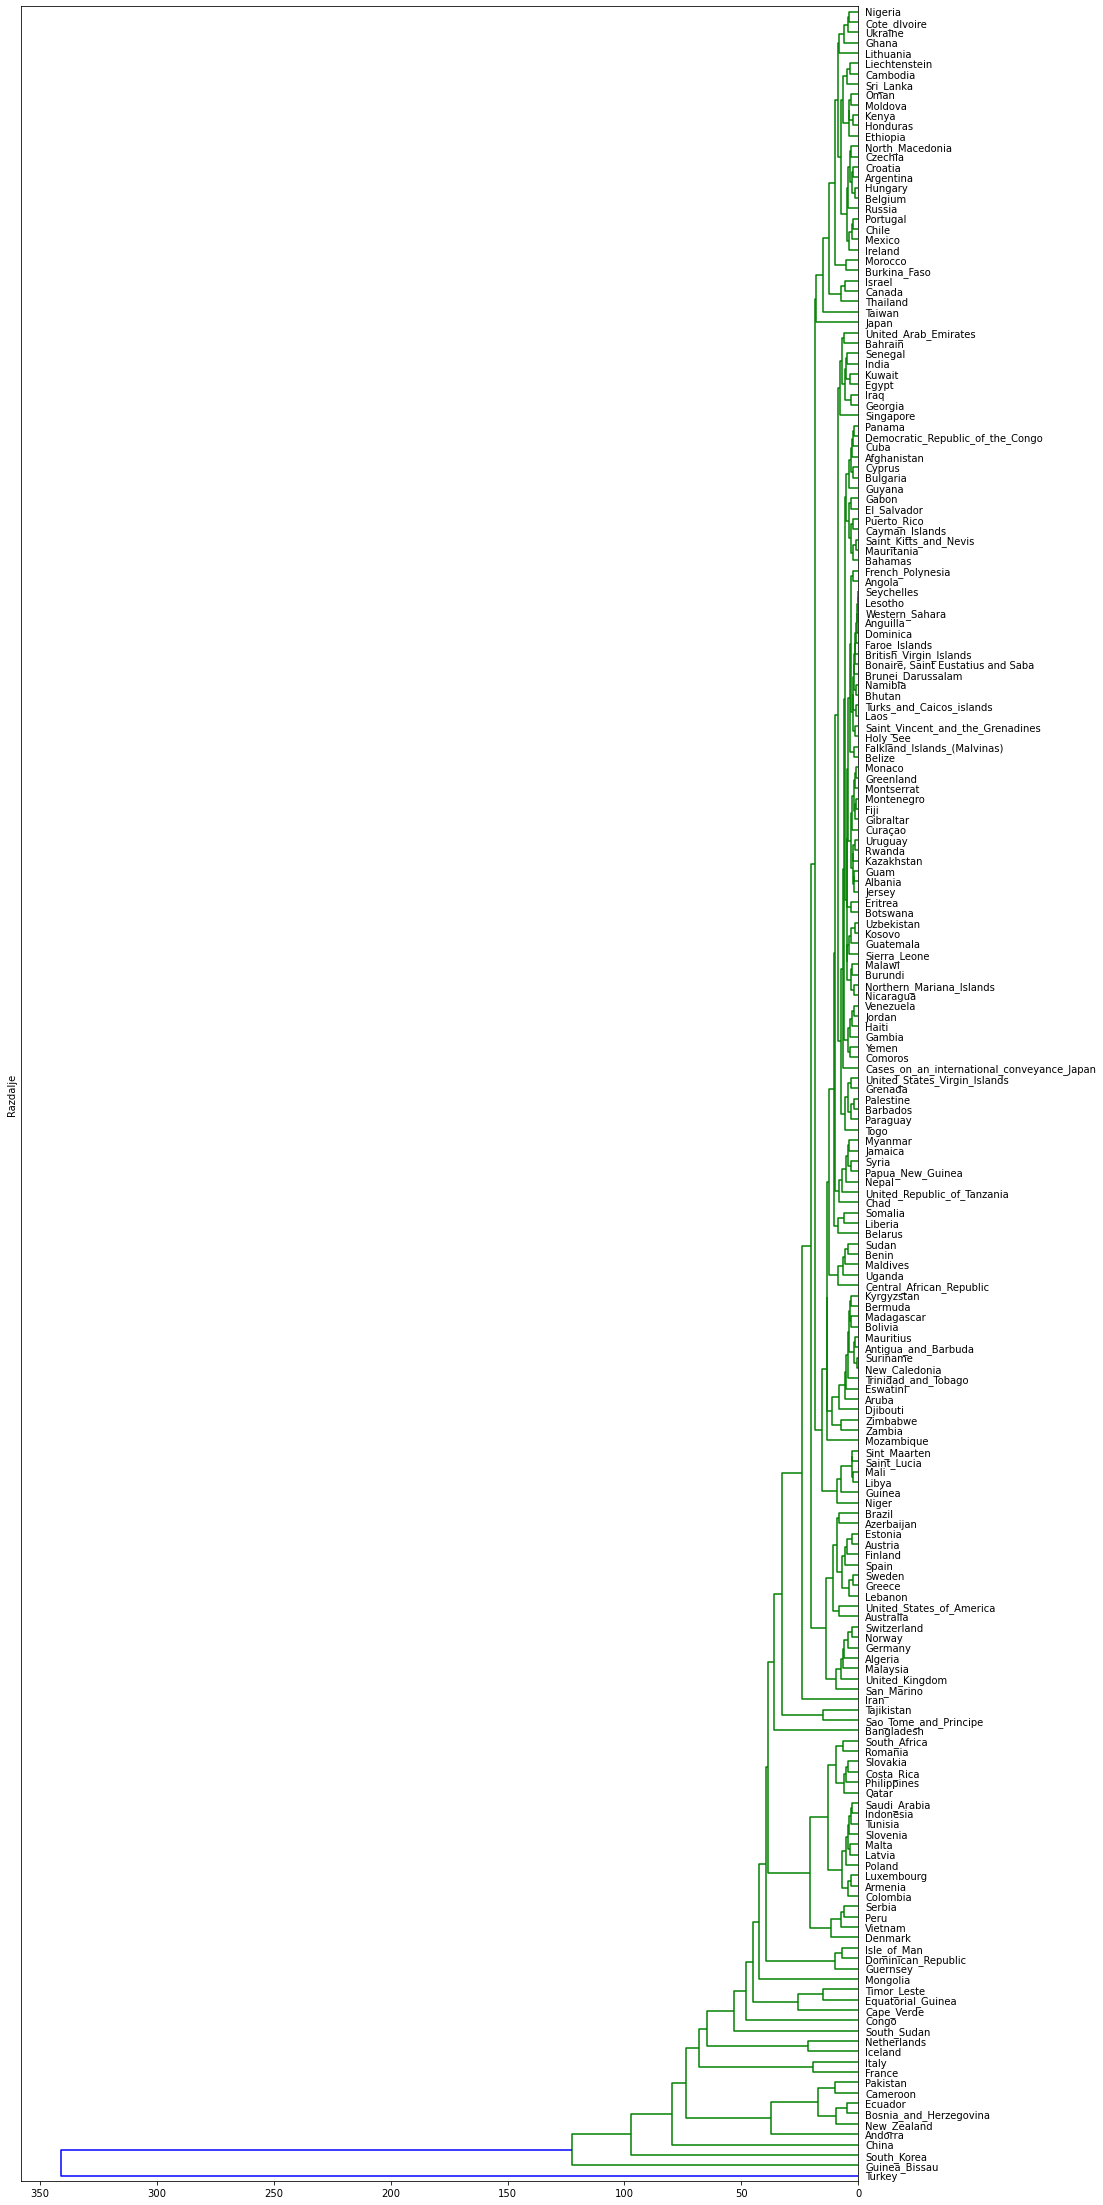

In [7]:
plt.figure(figsize=(15, 40))
dendogram = sch.dendrogram(linkage, labels=labels,orientation="left", leaf_font_size=10)
# plt.plot([0, 100], [t, t], "k--")
plt.ylabel("Razdalje")
plt.show()

## Gručenje glede na smrti

Gručim države za leto 2015. Parametri: smrtnost v smrti/milijon za vsak mesec v letu

In [45]:
# Load country population
populationFrame = pd.read_table("../podatki/total_population_by_sex.csv",sep=",",usecols=[1,4,8])
populationFrame["PopTotal"] = populationFrame["PopTotal"]*1000
populationFrame["PopTotal"] = pd.to_numeric(populationFrame["PopTotal"],downcast="signed")

# Location,Time,PopTotal

In [46]:
def getCountryPopulation(frame,year,country):
    return frame[(frame["Location"]==country)&((frame["Time"]==year))]["PopTotal"].iloc[0]

In [47]:
# List of all countries
countryList = populationFrame["Location"].unique()

In [48]:
# Get death by month list
# "Country or Area";"Year";"Month";"Value";
deathFrame = pd.read_table("../podatki/unData_deaths_per_month.txt",sep=";",usecols=[0,1,3,7],skiprows=range(39282,39400))

# Only use 2015 data
deathFrame=deathFrame[deathFrame["Year"]==2015]

# Month list
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [51]:
# Make a dictionary with country for key and array of deaths per each month per million eg. {"Slovenia": [2,3,5,2,4,2,4,5,3,2,4,5]}
monthDeaths = dict()
for cou in countryList:
    monthDeaths[cou]=[]
    population = getCountryPopulation(populationFrame,2015,cou)    
    for m in months:
        deathCount = deathFrame[(deathFrame["Country or Area"]==cou)&(deathFrame["Month"]==m)]["Value"]
        if not deathCount.empty:
            realCount = deathCount.iloc[0]
            monthDeaths[cou].append(realCount/population*1000)            

In [60]:
deaths = dict()
# Remove empty values
for c in monthDeaths.keys():
    if len(monthDeaths[c]) == 12:
        deaths[c] = monthDeaths[c]

In [64]:
# How many countries do we still got?
print(len(deaths.keys()))

80


In [66]:
# Making a matrix
labels = list(deaths.keys())
mortalityMatrix = []
for c in labels:
    mortalityMatrix.append(deaths[c])

In [67]:
# Creating a clustering model and a dendrogram
mortalityModel = sch.linkage(mortalityMatrix, method="ward")

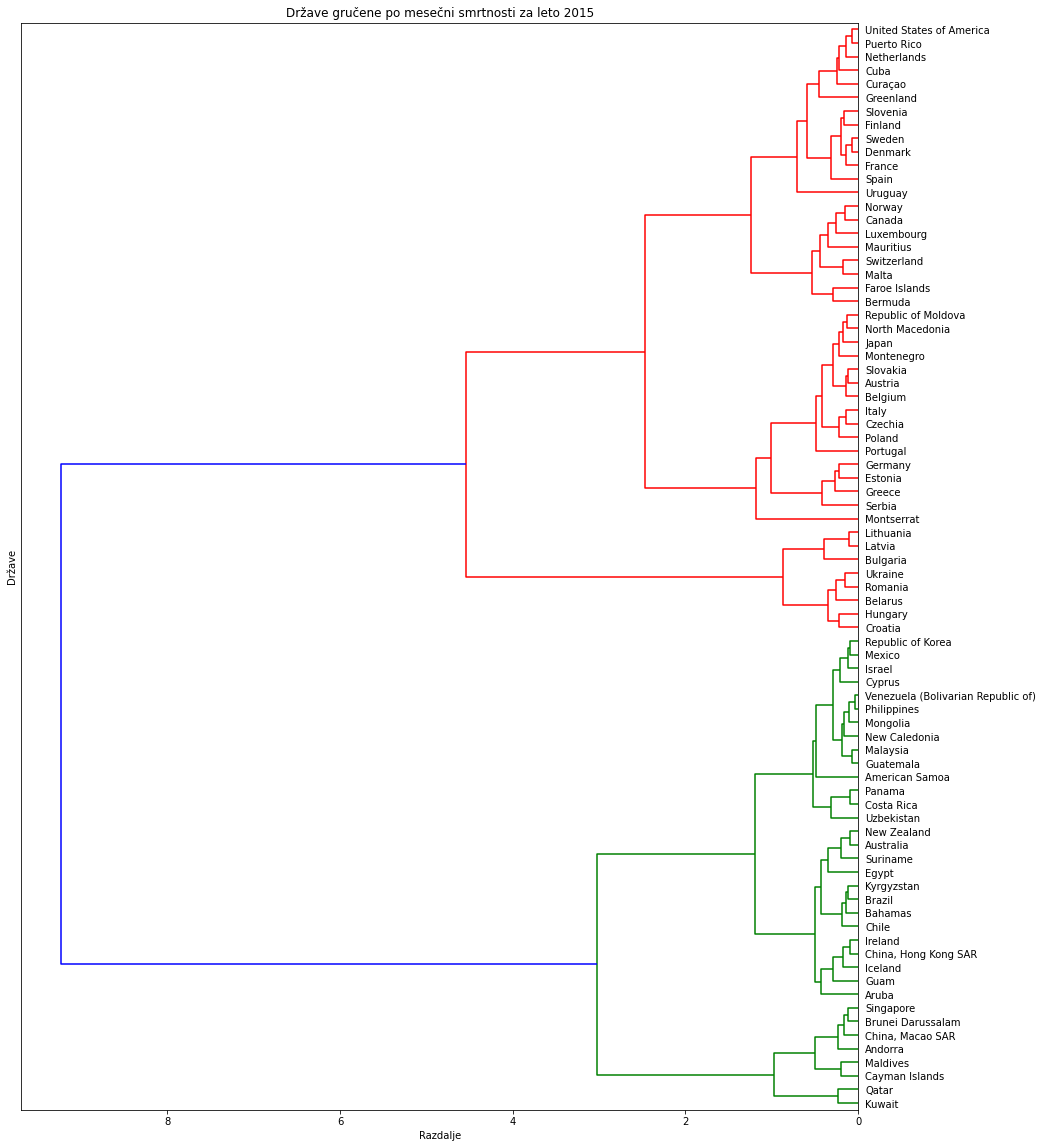

In [73]:
plt.figure(figsize=(15, 20))
dendrogram = sch.dendrogram(mortalityModel, labels=labels,orientation="left", leaf_font_size=10)
plt.title("Države gručene po mesečni smrtnosti za leto 2015")
plt.xlabel("Razdalje")
plt.ylabel("Države")
plt.show()